In [22]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import *

In [76]:
#generate a range of s and tau_star
def s_gen(tau_min=1, tau_max=100., buff_max=None, k=20, ntau=40, g=0.0):
    c = (tau_max/tau_min)**(1./(ntau-1))-1
    tau_star = tau_min*(1+c)**np.arange(ntau).astype(float)
    s = 1/tau_star
    return [tau_star, s]
[tau_star, S] = s_gen()
#print(S)

In [77]:
def stim_gen(i):
    global nf
    stim_vec = np.zeros(nf)
    if i is not None:
        stim_vec[i] = 1
    return stim_vec
def input_update(a,s,s_idx,fi_IN: None):
    global M
    global F
    global P
    #if fi_IN is not None:
        #print("Inputing stim", stim[fi_IN])
    f_IN = stim_gen(fi_IN)
    #eq 1
    F[s_idx] += -s*F[s_idx] + f_IN
    F[s_idx] = np.where(F[s_idx]<0, 0, F[s_idx])
    #eq 2
    P_IN = np.dot(M[s_idx], f_IN)
    #eq 3
    P[s_idx] +=  s*P[s_idx] + P_IN - P[0]
    P[s_idx] = np.where(P[s_idx]<0, 0, P[s_idx])
    #find stimulis from the past that are still active & update associations
    if fi_IN is not None:
        for past_stim in np.flatnonzero(F[s_idx]):
            #Avoiding self-prediction updates
            if past_stim != fi_IN:
                #print("Past stim is %s and current stim is %s" %(past_stim, fi_IN))
                #eq4 - make sure we're indexing M correctly
                M[s_idx][fi_IN,past_stim] = a * M[s_idx][fi_IN,past_stim] + (1-a) * F[s_idx][past_stim]
def detect_notstim(a,t,s,s_idx,fi_IN:None):
    global M
    global F
    global P
    predicted = np.where(P[s_idx]>=1)[0]
    #iterate through them
    for p in predicted:
        if p == fi_IN:
            #print(stim[p], "Observed & Predicted with p=%s! at at s=%s and t=%s"
                  %(P[s_idx][p],s,t))
            P[s_idx][p] = 0
        else:
            P[s_idx][p] = 0
            if p < 2:
                #print(stim[p+2], "predicted at s=%s and t=%s" %(s,t))
                #add 2 to get the not-stimuli equivalent
                input_update(a,s,s_idx,fi_IN=p+2)
            else:
                #print(stim[p], "predicted at s=%s and t=%s" %(s,t))
                input_update(a,s,s_idx, fi_IN=p)
def timestep_update(a,t,S,fi_IN: None):
    for s_idx, s in enumerate(S):
        input_update(a,s,s_idx,fi_IN)
        detect_notstim(a,t,s,s_idx,fi_IN) 

In [143]:
# no. of stimuli x2 for not-stimuli as well
nf = 2*2
stim = {
    0:"X",
    1:"Y",
    2:"NotX",
    3:"NotY"
}
# variables
dt = 0.1
A = np.arange(0,1,0.2)
a = 0.1

In [166]:
#time steps
t_max = 15
T = np.arange(0,t_max, dt)
#stim presentation
t_x1 = 1
t_y = 3
t_x2 = 7
f = [[0,1],[1,3],[0,7],[0,t_max+0.1]]
#tracking
#pick some s values to track
s_track = np.arange(0,40,1)
P_tracker = np.ndarray(shape=(len(T), len(s_track), nf), dtype=float)
F_tracker = np.ndarray(shape=(len(T), len(s_track), nf), dtype=float)

In [167]:
M = np.zeros([len(S), nf, nf])
F = np.zeros([len(S), nf])
P = np.zeros([len(S), nf])
for t in T:
    if f[0][1] == t:
        fi_IN = f[0][0]
        timestep_update(a,t,S,fi_IN=fi_IN)
        f.pop(0)
    else:
        timestep_update(a,t,S,fi_IN=None)
    t_idx = int(t*10)
    for s_idx, s in enumerate(s_track):
        P_tracker[t_idx,s_idx] = P[s]
        F_tracker[t_idx,s_idx] = F[s]

NotY predicted at s=0.1343399332598902 and t=9.4
NotY predicted at s=0.11937766417144383 and t=9.4
NotY predicted at s=0.10608183551394501 and t=9.4
NotY predicted at s=0.09426684551178867 and t=9.4
NotY predicted at s=0.08376776400682932 and t=9.4
NotY predicted at s=0.07443803013251701 and t=9.4
NotY predicted at s=0.06614740641230162 and t=9.4
NotY predicted at s=0.05878016072274924 and t=9.4
NotY predicted at s=0.05223345074266852 and t=9.4
NotY predicted at s=0.046415888336127885 and t=9.4
NotY predicted at s=0.041246263829013606 and t=9.4
NotY predicted at s=0.03665241237079636 and t=9.4
NotY predicted at s=0.032570206556597904 and t=9.4
NotY predicted at s=0.19144819761699602 and t=9.5
NotY predicted at s=0.1701254279852591 and t=9.5
NotY predicted at s=0.1511775070615664 and t=9.5
NotY predicted at s=0.028942661247167573 and t=9.5
NotY predicted at s=0.02571913809059351 and t=9.5
NotY predicted at s=0.21544346900318861 and t=9.600000000000001
NotY predicted at s=0.0228546386413

In [168]:
#plot individual s value
#fig = plt.figure(figsize = (6,10))
#ax = fig.subplots(2,1)
#ax[0].plot(T, F_tracker[:,0,0])
#ax[0].set_title("F Values, s=%s" %(S[s_track[1]]))
#ax[0].set_xlabel("Time")
#ax[0].legend(['X', 'Y','Not X', 'Not Y'])

#ax[1].plot(T, P_tracker[:,0,1])
#ax[1].set_title("P Values, s=%s" %(S[s_track[1]]))
#ax[1].set_xlabel("Time")
#ax[1].legend(['X', 'Y','Not-X (X predicted, not observed)', 'Not Y (Y predicted, not observed)']
#             ,bbox_to_anchor=(1.1, 1))

Text(0.5, 1.0, 'Prediction P(s)')

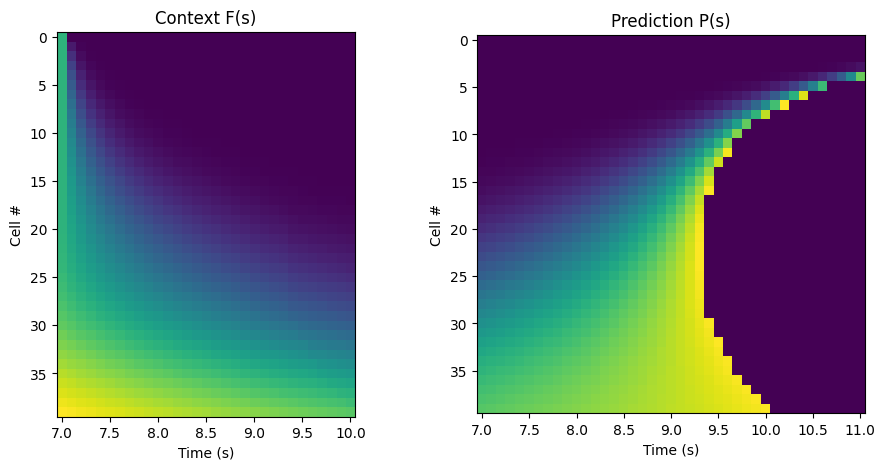

In [192]:
#imshow plot
fig3, axe3 = plt.subplots(1,2,figsize = (11, 5))
axe3[0].imshow(F_tracker[70:101,:,0].T)
axe3[0].set_xlabel("Time (s)")
axe3[0].set_xticks(np.arange(0,31,5), np.arange(7, 10.1, 0.5))
axe3[0].set_ylabel("Cell #")
axe3[0].set_title("Context F(s)")

axe3[1].imshow(P_tracker[70:111,:,1].T)
axe3[1].set_xlabel("Time (s)")
axe3[1].set_xticks(np.arange(0,41,5), np.arange(7, 11.1, 0.5))
axe3[1].set_ylabel("Cell #")
axe3[1].set_title("Prediction P(s)")

In [183]:
print(np.arange(70,101,5))
print(np.arange(7, 10, 0.5))

[ 70  75  80  85  90  95 100]
[7.  7.5 8.  8.5 9.  9.5]


Text(10, 2.8, 'Y Predictions')

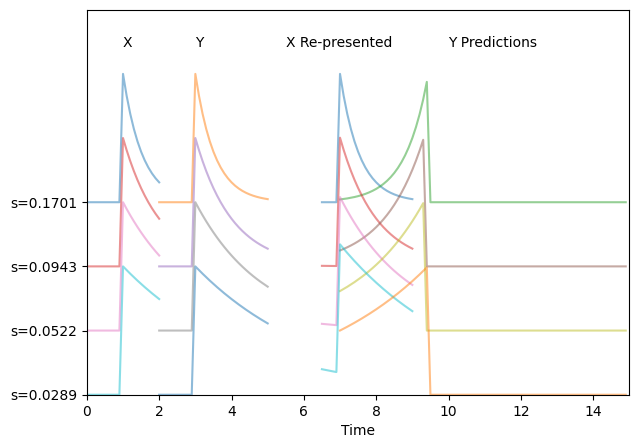

In [140]:
#line plot
y_ticks = np.arange(0, len(s_track)+0.5, 1)[::-1]/2
fig2,ax2 = plt.subplots(figsize = (7,y_ticks[0]*2+1))
for idx, y_tick in enumerate(y_ticks[1:]):
    F_X_masked = np.ma.masked_where(((T>t_x1+1)&(T<t_x2-0.5))|(T>t_x2+2),
                                    (F_tracker[:,idx,0]+y_tick))
    F_Y_masked = np.ma.masked_where((T<t_y-1)|(T>t_y+2),
                                    (F_tracker[:,idx,1]+y_tick))
    P_masked = np.ma.masked_where((T<t_x2),
                                  (P_tracker[:,idx,1]+y_tick))
    #P_masked = P_tracker[:,idx,1]+plot_inc
    ax2.plot(T,F_X_masked, alpha=0.5)
    ax2.plot(T,F_Y_masked, alpha=0.5)
    ax2.plot(T,P_masked,alpha=0.5)
ax2.set_ylim(0, y_ticks[0]+1)
ax2.set_xlim(0, t_max)
ax2.set_xlabel('Time')

def tick_labels(S, s_track):
    labels = np.array(0)
    for s in s_track:
        labels = np.append(labels, 's=%s' %(S[s].round(4)))
    return labels[1:]
ax2.set_yticks(y_ticks[1:], tick_labels(S, s_track))

text_height = y_ticks[0]+0.8
ax2.text(t_x1,text_height, "X", verticalalignment='top')
ax2.text(t_y,text_height, "Y", verticalalignment='top')
ax2.text(t_x2-1.5,text_height, "X Re-presented", verticalalignment='top')
ax2.text(t_x2+3,text_height, "Y Predictions", verticalalignment='top')

In [123]:
#plot using imshow
#fig = plt.figure(figsize = (5,10))
#ax = fig.subplots(2,1)
#ax[0].imshow(F_tracker, aspect='auto')
#ax[0].set_title("F Values, s=%s" %(S[s_track]))
#ax[0].set_ylabel("Time")
#ax[0].set_xticks(np.arange(4),['X', 'Y','Not X', 'Not Y'])
#ax[1].imshow(P_tracker, aspect='auto')
#ax[1].set_title("P Values, s=%s" %(S[s_track]))
#ax[1].set_ylabel("Time")
#ax[1].set_xticks(np.arange(4),['X', 'Y','Not X', 'Not Y'])
#ax[2].imshow(P_max, aspect='auto')
#ax[2].set_title("P Values, s=%s" %(S[-1]))
#ax[2].set_ylabel("Time")
#ax[2].set_xticks(np.arange(4),['X', 'Y','Not X', 'Not Y'])

In [124]:
#plot tracked variables through time - doesn't work yet
#x = np.arange(nf)
#fig = plt.figure()
#ax = fig.subplots(3,1)
#i = 0
#F_plot = ax[0].scatter(x, F_tracker[i])
#P_plot = ax[2].scatter(x, P_tracker[i])
#M_plot = ax[1].pcolormesh(M_tracker[i])

#def update(i=0.0):
#    idx = int(i*10)
#    F_plot.set_offsets(np.c_[x,F_tracker[idx]])
#    P_plot.set_offsets(np.c_[x,P_tracker[idx]])
#    M_plot.set_array(M_tracker[idx])
#    #scatter.set_ydata(Tracker[idx])
#    fig.canvas.draw_idle()

#interact(update, i = (0.0,t_max,dt));